# Women's E-Commerce Clothing Reviews

**f1-score:**

Бинарная классификация - `0.8507015684469733`

Многоклассовая классификация - `0.6033866825602262`

## Импорт библиотек, константы

In [ ]:
!pip install kaggle -q
!mkdir -p ~/.kaggle
!echo '{"username":"USEERNAAME","key":"KEEEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews

Dataset URL: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews
License(s): CC0-1.0
womens-ecommerce-clothing-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip womens-ecommerce-clothing-reviews.zip

Archive:  womens-ecommerce-clothing-reviews.zip
replace Womens Clothing E-Commerce Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install emoji datasets transformers pyarrow==14.0.1 requests==2.31.0 -q

In [ ]:
import re
import nltk
import emoji
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import pos_tag
from typing import Match
from tqdm.auto import tqdm
from torch.optim import AdamW
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.metrics import confusion_matrix
from datasets import load_metric, load_dataset
from transformers import get_scheduler, AutoTokenizer, AutoModel, AutoModelForSequenceClassification

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

LEMMATIZER = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Описание датасета


Описание датасета: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

Датасет: https://nextcloud.fintechhub.ru/index.php/s/TFcDB7dDZmQE2bt

- Clothing ID: Целочисленная категориальная переменная, которая относится к конкретному рассматриваемому предмету одежды.
- Age: Положительная целочисленная переменная, обозначающая возраст рецензента.
- Title: Строковая переменная для заголовка отзыва.
- Review Text: Строковая переменная для текста отзыва.
- **Rating: Положительная порядковая целочисленная переменная для оценки продукта, выставленной клиентом, от 1 (худшая) до 5 (лучшая).**
- **Recommended IND: Бинарная переменная, указывающая, рекомендует ли клиент продукт, где 1 - рекомендует, 0 - не рекомендует.**
- Positive Feedback Count: Положительное целое число, документирующее количество других клиентов, которые сочли этот отзыв полезным.
- Division Name: Категориальное название высокоуровневого подразделения продукта.
- Department Name: Категориальное название отдела продукта.
- Class Name: Категориальное название класса продукта.

## Предобработка текстов

In [ ]:
df = (
    pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
    [['Review Text', 'Rating', 'Recommended IND']]
    .rename(columns={
        'Review Text': 'text',
        'Rating': 'rating',
        'Recommended IND': 'labels'})
    )

df.head()

text  rating  labels
0  Absolutely wonderful - silky and sexy and comf...       4       1
1  Love this dress!  it's sooo pretty.  i happene...       5       1
2  I had such high hopes for this dress and reall...       3       0
3  I love, love, love this jumpsuit. it's fun, fl...       5       1
4  This shirt is very flattering to all due to th...       5       1

In [ ]:
df.labels.value_counts()

labels
1    19314
0     4172
Name: count, dtype: int64

In [ ]:
df.rating.value_counts()

rating
5    13131
4     5077
3     2871
2     1565
1      842
Name: count, dtype: int64

Видим, что датасет не сбалансирован

In [ ]:
df.isnull().sum()

text      845
rating      0
labels      0
dtype: int64

Удалим пропуски из датасета

In [ ]:
df = df.dropna()

In [ ]:
STOP_WORDS = set(stopwords.words('english'))
ADDITIONAL_STOP_WORDS = {'color', 'dress', 'fabric', 'fit', 'great', 'like',
                         'look', 'love', 'size', 'top', 'wear', 'would', 'one'}
STOP_WORDS = STOP_WORDS.union(ADDITIONAL_STOP_WORDS)

In [ ]:
# Преобразование тегов POS в формат для WordNetLemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
def preprocess_text(text: str) -> str:

  # Преобразование эмодзи и смайликов в слова
  text = emoji.replace_emoji(text)
  text = text.replace(':', '').replace('_', ' ')

  # Замена символьных смайликов на слова
  smile_dict = {
      ':)': 'smile', ':(': 'sad', ':D': 'laugh', ':P': 'tongue',
      ';)': 'wink', ':|': 'neutral', ':/': 'confused',
      '=)': 'smile', '=D': 'laugh', '=(': 'sad'
      }
  for smile, word in smile_dict.items():
    text = text.replace(smile, ' ' + word + ' ')

  # Приводим текст к нижнему регистру
  text = text.lower()

  # Удаление пунктуации

  # Никнеймы, хэштеги, URL-адреса и символы новой строки
  text = re.sub(r'@\w+|#[\w-]+|http\S+|\n', '', text)

  # Удаляем пунктуацию, не разделяя слова и знаки препинания
  text = re.sub(r'[^\w\s]', ' ', text)

  # Токенизация
  text = word_tokenize(text)

  # POS тэггинг
  pos_tags = pos_tag(text)

  # Лемматизация
  lemmatized_tokens = [
      LEMMATIZER.lemmatize(word, get_wordnet_pos(tag))
      for word, tag in pos_tags
      ]

  # Удаление стоп-слов и фильтрация слов, содержащих меньше двух букв
  tokens = [
      word for word in lemmatized_tokens
      if word not in STOP_WORDS and re.match(r'^[a-zA-Z]{2,}$', word)
      ]

  return ' '.join(tokens)

In [ ]:
# Предобработка датасета
df_preprocessed = df.copy()
df_preprocessed['text'] = df_preprocessed['text'].apply(preprocess_text)

Посмотрим, как работает функция предобработки текста

In [ ]:
random_indices = np.random.choice(df.index.tolist(), 5, replace=False)

for i in random_indices:
    print('Ориг:', df['text'][i])
    print('Чист:', df_preprocessed['text'][i], '\n')

Ориг: Love this top! it is almost universally flattering, and washes beautifully. it is as easy as throwing on a sweatshirt with leggings, but soooo much better! if you are on the fence on this one, i highly recommend you give it a try.
Чист: almost universally flattering wash beautifully easy throw sweatshirt legging soooo much good fence highly recommend give try 

Ориг: I'm 6 ft tall and usually wear a size 10/12, but had to size up to a 14 because this dress runs a bit small around the waist. it's a beautiful dress. it hit me right below the knee, so might be long on shorter gals. i received many compliments on this dress. the colors are beautiful. the main color of the dress is a dark navy. it looked black online. definitely buy this dress! it's a great work dress and you won't be sorry that you did.
Чист: ft tall usually run bit small around waist beautiful hit right knee might long short gal receive many compliment beautiful main dark navy black online definitely buy work win so

In [ ]:
def create_wordcloud(text: str, title: str) -> None:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

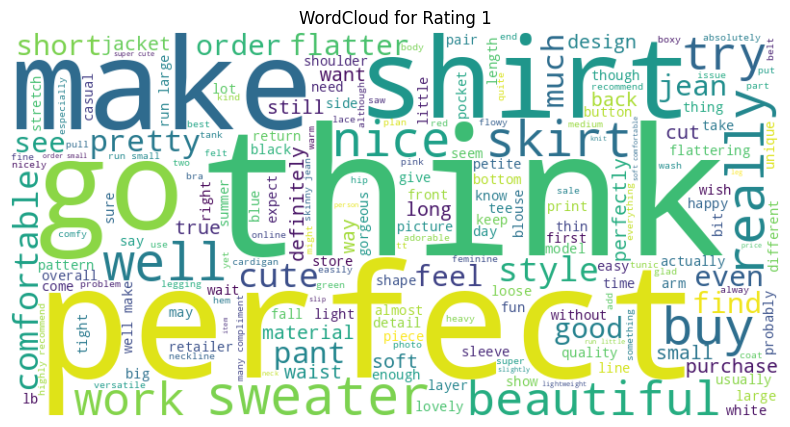

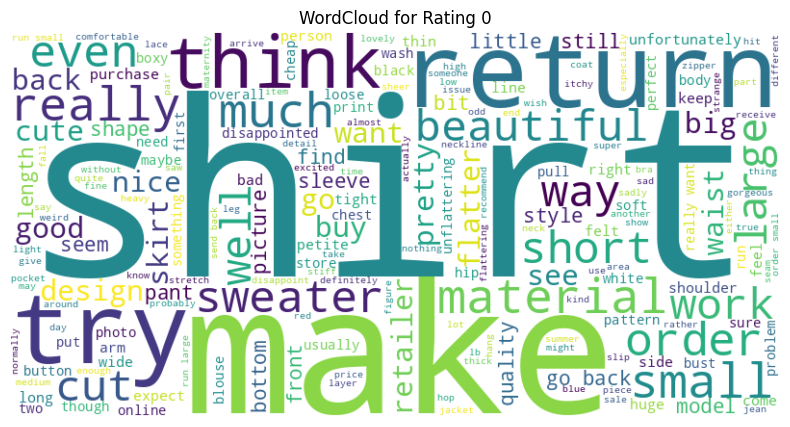

In [ ]:
for label in df_preprocessed['labels'].unique():
  reviews = df_preprocessed[df_preprocessed['labels'] == label]['text']
  processed_text = ' '.join(reviews)
  create_wordcloud(processed_text, f'WordCloud for Rating {label}')

Видим, что WordClouds значительно отличаются у двух классов, значит мы удалили достаточно стоп-слов

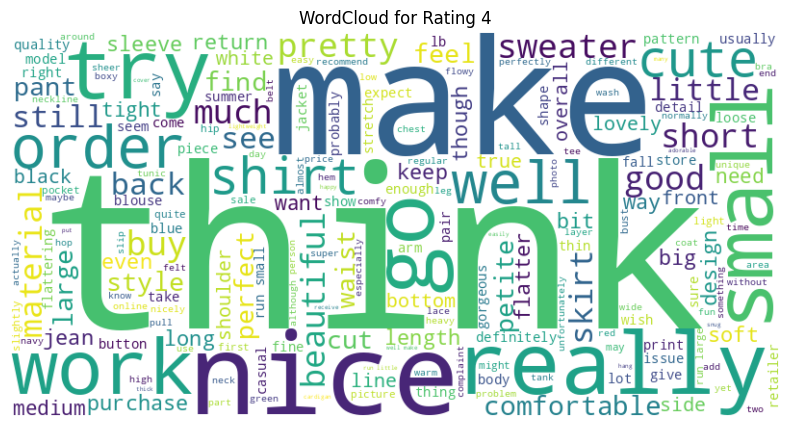

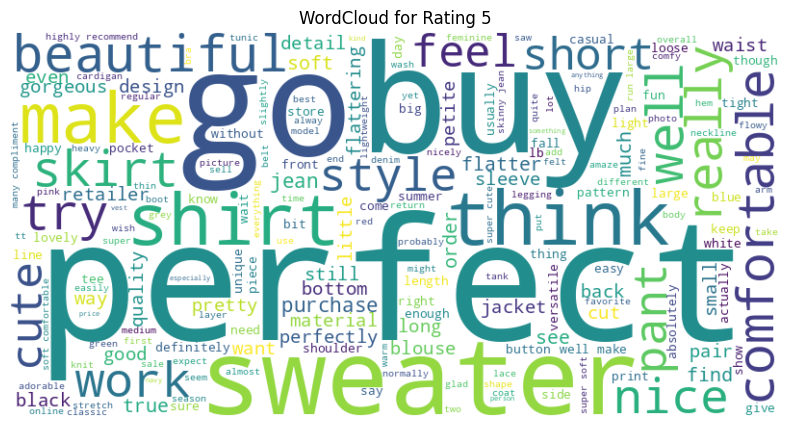

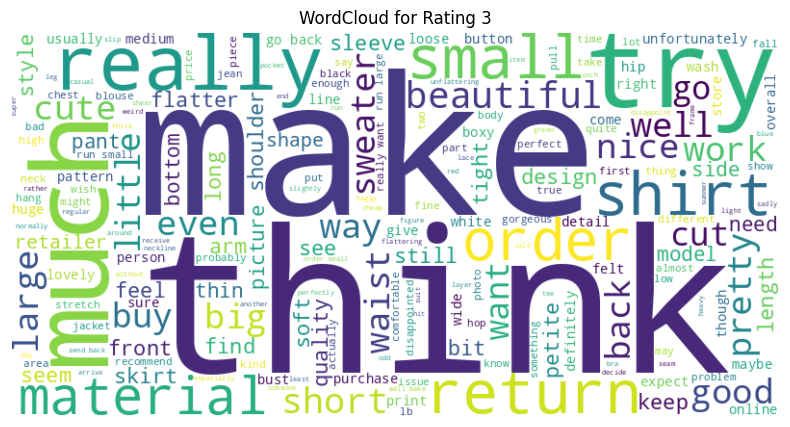

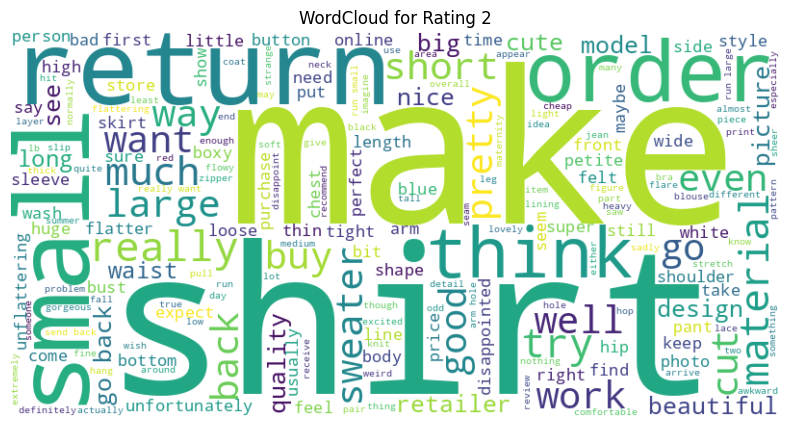

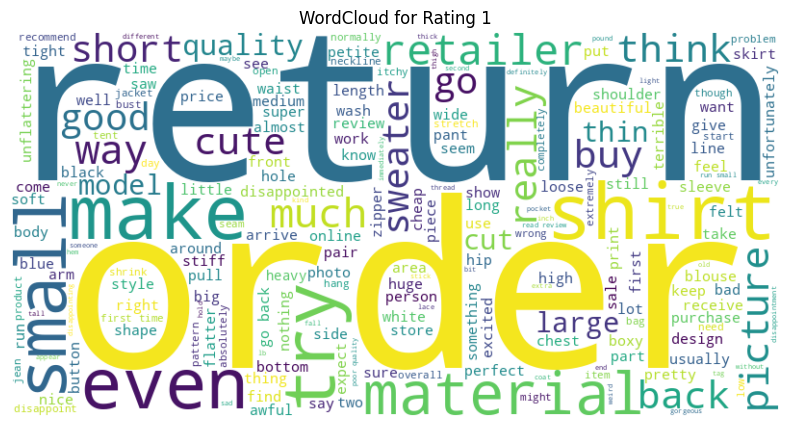

In [ ]:
for rating in df_preprocessed['rating'].unique():
    reviews = df_preprocessed[df_preprocessed['rating'] == rating]['text']
    processed_text = ' '.join(reviews)
    create_wordcloud(processed_text, f'WordCloud for Rating {rating}')

WordClouds для многоклассовой классификации (бонусное задание) часто пересекаются между собой. Это может быть вредным для работы модели. При предсказании рейтинга будет необходимо расширить список стоп-слов. На данном этапе не будем этого делать, чтобы не терять большое количество информации.

Сбалансируем классы

In [ ]:
# Определение количества записей в каждом классе
class_counts = df_preprocessed['labels'].value_counts()
min_class = class_counts.idxmin()
min_class_count = class_counts.min()

# Разделение датасета на классы
df_class_0 = df_preprocessed[df_preprocessed['labels'] == 0]
df_class_1 = df_preprocessed[df_preprocessed['labels'] == 1]

# Случайное уменьшение выборки большего класса
if len(df_class_0) > len(df_class_1):
    df_class_0_under = df_class_0.sample(min_class_count, random_state=42)
    df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)
else:
    df_class_1_under = df_class_1.sample(min_class_count, random_state=42)
    df_balanced = pd.concat([df_class_0, df_class_1_under], axis=0)

# Перемешивание сбалансированного датасета
df_preprocessed = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Сохранение предобработанного датасета
df_preprocessed.to_csv('preprocessed_data.csv', index=False)

## Бинарная классификация

In [ ]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
full_dataset = load_dataset('csv', data_files='preprocessed_data.csv')
full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)

full_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/8202 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'rating', 'labels'],
        num_rows: 8201
    })
})

In [ ]:
tokenizer.tokenize(full_dataset['train'][1]['text'])

['may',
 'Ġbeautiful',
 'Ġever',
 'Ġpurchase',
 'Ġretailer',
 'Ġgorgeous',
 'Ġclassy',
 'Ġcomfortable',
 'Ġkind',
 'Ġwish',
 'Ġanother',
 'Ġpattern',
 'Ġavailable',
 'Ġcould',
 'Ġbuy',
 'Ġrun',
 'Ġlarge',
 'Ġbuy',
 'Ġsmall',
 'Ġusually',
 'Ġfeel',
 'Ġchic',
 'Ġconfident',
 'Ġflattering',
 'Ġshoulder',
 'Ġperfect']

In [ ]:
dataset = full_dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'rating', 'labels'],
        num_rows: 6560
    })
    test: Dataset({
        features: ['text', 'rating', 'labels'],
        num_rows: 1641
    })
})

In [ ]:
pd.Series(dataset['test']['labels']).value_counts()

1    824
0    817
Name: count, dtype: int64

In [ ]:
# визуализируем один пример
dataset['train'][0]

{'text': 'picture structured blazer tire get extra small big',
 'rating': 3,
 'labels': 0}

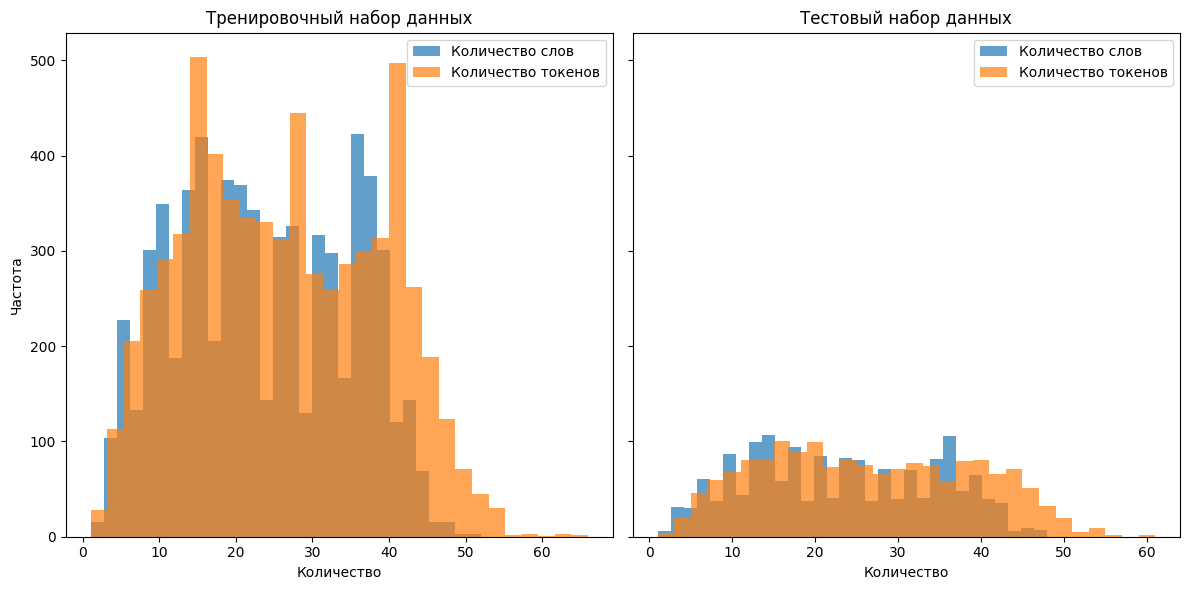

In [ ]:
# Подсчет количества слов и токенов с использованием токенизатора
train_word_counts = [len(example['text'].split()) for example in dataset['train']]

train_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['train']]

test_word_counts = [len(example['text'].split()) for example in dataset['test']]
test_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['test']]

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Гистограмма для тренировочного набора данных
axes[0].hist(train_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[0].set_title('Тренировочный набор данных')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Частота')
axes[0].legend()

# Гистограмма для тестового набора данных
axes[1].hist(test_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[1].hist(test_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[1].set_title('Тестовый набор данных')
axes[1].set_xlabel('Количество')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=80,
                                padding='max_length'), batched=True)

Map:   0%|          | 0/6560 [00:00<?, ? examples/s]

Map:   0%|          | 0/1641 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'rating', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6560
    })
    test: Dataset({
        features: ['text', 'rating', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1641
    })
})

In [ ]:
dataset = dataset.remove_columns(['text', 'rating'])

In [ ]:
# переносим на гпу
dataset.set_format(type='torch', device='cuda')

In [ ]:
# создаем загрузчики данных
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=16)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=8)

In [ ]:
next(iter(train_dataloader))

{'labels': tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0'),
 'input_ids': tensor([[    0, 33869,  1400,  ...,     1,     1,     1],
         [    0,  3746,   455,  ...,     1,     1,     1],
         [    0, 17195, 29894,  ...,     1,     1,     1],
         ...,
         [    0,   438,  4467,  ...,     1,     1,     1],
         [    0, 22111,   277,  ...,     1,     1,     1],
         [    0, 32835,   269,  ...,     1,     1,     1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-4)

num_epochs = 10

num_training_steps = num_epochs * len(train_dataloader)

# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps= int(0.1 * num_epochs * len(train_dataloader)), # ~10% от общего числа шагов оптимально
    num_training_steps=num_training_steps
)

In [ ]:
best_f1 = 0.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

running_loss = []

for epoch in range(num_epochs):
    print(40*'-', f'\nEpoch {epoch+1}')

    # Переводим модель в режим обучения
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader), desc='Training')

    # Итерируемся по данным для обучения
    for i, batch in enumerate(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        # Получаем прогнозы и потери от модели
        outputs = model(**batch)
        loss = outputs.loss

        # Выполняем обратное распространение и шаг оптимизатора
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Обновляем планировщик скорости обучения
        optimizer.zero_grad()  # Очищаем градиенты

        running_loss.append(loss.item())
        pbar.set_postfix({'running_loss': np.mean(running_loss[-25:])})

    # Валидация модели
    print('\nValidating...')
    model.eval()  # Переводим модель в режим валидации

    # Инициализируем метрики
    f1 = load_metric('f1', trust_remote_code=True)
    acc = load_metric('accuracy', trust_remote_code=True)
    precision = load_metric('precision', trust_remote_code=True)
    recall = load_metric('recall', trust_remote_code=True)

    val_loss = []

    pbar = tqdm(test_dataloader, total=len(test_dataloader), desc='Validation')
    # Итерируемся по валидационным данным
    for batch in tqdm(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():  # Выполняем без расчета градиентов
            outputs = model(**batch)

        logits = outputs.logits.detach().cpu()
        predictions = torch.argmax(logits, dim=-1)

        # Обновляем метрики
        f1.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        acc.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        precision.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        recall.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())

        # Сохраняем потери
        val_loss.append(outputs.loss.item())
        pbar.set_postfix({'val_loss': np.mean(val_loss[-25:])})

    # Выводим итоги по метрикам
    print('Weighted Summary:')
    test_acc = acc.compute()['accuracy']
    test_precision = precision.compute(average='weighted')['precision']
    test_recall = recall.compute(average='weighted')['recall']
    f1_weighted = f1.compute(average='weighted')['f1']
    print(f'[{epoch+1}] Test Accuracy: {test_acc:.4f}')
    print(f'[{epoch+1}] Test Precision: {test_precision:.4f}')
    print(f'[{epoch+1}] Test Recall: {test_recall:.4f}')
    print(f'[{epoch+1}] Test F1: {f1_weighted:.4f}')

    # Сохраняем модель при улучшении F1
    if f1_weighted > best_f1:
        best_f1 = f1_weighted
        model.save_pretrained(f"best_model_jul_2024_f1_max={best_f1}")
        print(f"New best F1: {best_f1}. Model saved.")

Лучшее значение f1 среди предобученных моделей: 0.8507015684469733.

Попробуем классификатор на своих примерах

In [ ]:
# Загрузка модели и токенизатора
model_path = "/content/best_model_jul_2024_f1_max=0.8507015684469733"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Определение устройства (CPU или GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Словарь для интерпретации результатов
class_dict = {
    0: "негативный отзыв",
    1: "положительный отзыв"
}

# Функция для предсказания класса
def predict_class(text):
    # Подготовка входных данных
    inputs = tokenizer(text, truncation=True, max_length=80, padding='max_length', return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Получение предсказания
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class, class_dict[predicted_class]

# Основной цикл для взаимодействия с пользователем
while True:
    user_input = input("Введите отзыв для классификации (или 'q' для выхода): ")

    if user_input.lower() == 'q':
        break

    user_input = preprocess_text(user_input)
    predicted_class, class_name = predict_class(user_input)
    print(f"Предсказанный класс: {predicted_class} ({class_name})")

Заметно, что классификатор не всегда справляется с задачей.

Для удачной классифиакции необходимо написать объемный отзыв с использованием достаточного количества явных оценочных слов.

## Многоклассовая классификация (бонусное задание) - предобработка текста

Немного изменим предобрабку текста, чтобы решить задачу многоклассовой классификации (колонка Rating).

In [ ]:
df

text  rating  labels
0      Absolutely wonderful - silky and sexy and comf...       4       1
1      Love this dress!  it's sooo pretty.  i happene...       5       1
2      I had such high hopes for this dress and reall...       3       0
3      I love, love, love this jumpsuit. it's fun, fl...       5       1
4      This shirt is very flattering to all due to th...       5       1
...                                                  ...     ...     ...
23481  I was very happy to snag this dress at such a ...       5       1
23482  It reminds me of maternity clothes. soft, stre...       3       1
23483  This fit well, but the top was very see throug...       3       0
23484  I bought this dress for a wedding i have this ...       3       1
23485  This dress in a lovely platinum is feminine an...       5       1

[22641 rows x 3 columns]

In [ ]:
df.rating.value_counts()

rating
5    12540
4     4908
3     2823
2     1549
1      821
Name: count, dtype: int64

Расширим список слов при помощи WordCloud и анализа их частотности, чтобы уменьшить пересечения пяти классов.

In [ ]:
STOP_WORDS = set(stopwords.words('english'))
ADDITIONAL_STOP_WORDS = {'dress', 'top',  'look', 'love', 'fit', 'wear',
                         'fabric', 'great', 'color', 'think', 'make', 'size',
                         'shirt', 'return', 'really', 'try', 'order', 'one',
                         'well', 'small', 'go', 'back', 'work', 'want',
                         'material', 'like', 'would', 'much', 'get', 'little',
                         'large', 'short', 'cute', 'way'}
STOP_WORDS = STOP_WORDS.union(ADDITIONAL_STOP_WORDS)

In [ ]:
# Предобработка датасета
df_multi = df.copy()
df_multi['text'] = df_multi['text'].apply(preprocess_text)

In [ ]:
random_indices = np.random.choice(df.index.tolist(), 5, replace=False)

for i in random_indices:
    print('Ориг:', df['text'][i])
    print('Чист:', df_multi['text'][i], '\n')

Ориг: Received this and love the style, but it falls just a little below my waist and i like my tops to be longer.  it'll definitely fit a shorter torso.
Чист: receive style fall waist long definitely torso 

Ориг: Flattering, flowy, comfortable. the back strops have elastic so easy on and off. flows when you walk, the ties have two different types of black fabric, matching knit on one side, a matte crepe on the other. love the pockets, very versatile piece.
Чист: flatter flowy comfortable strop elastic easy flow walk tie two different type black match knit side matte crepe pocket versatile piece 

Ориг: I ordered down a size based on other reviews. i am 5' tall, 110 lbs and a size 26 is a great fit. i ordered both the navy and turquoise colors. my only complaint is the turquoise color is not the vibrant blue in the photo but more of a green tone.
Чист: base review tall lb navy turquoise complaint turquoise vibrant blue photo green tone 

Ориг: I agree with the other reviewers - the fa

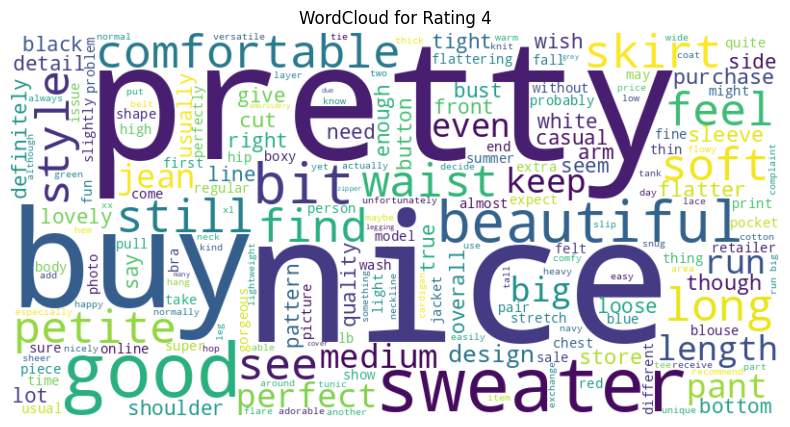

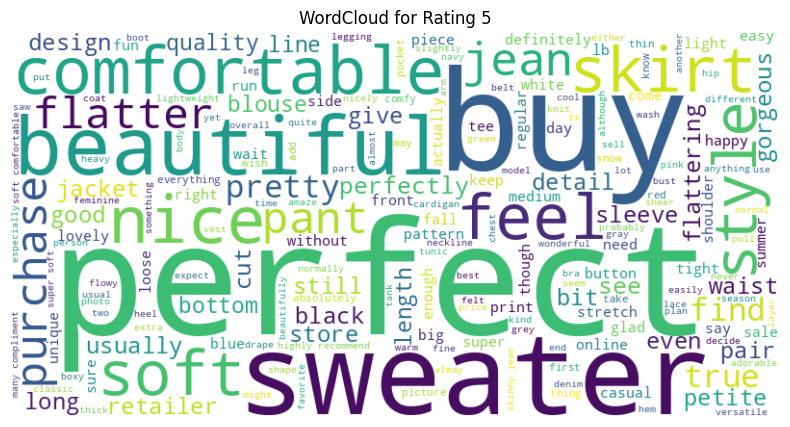

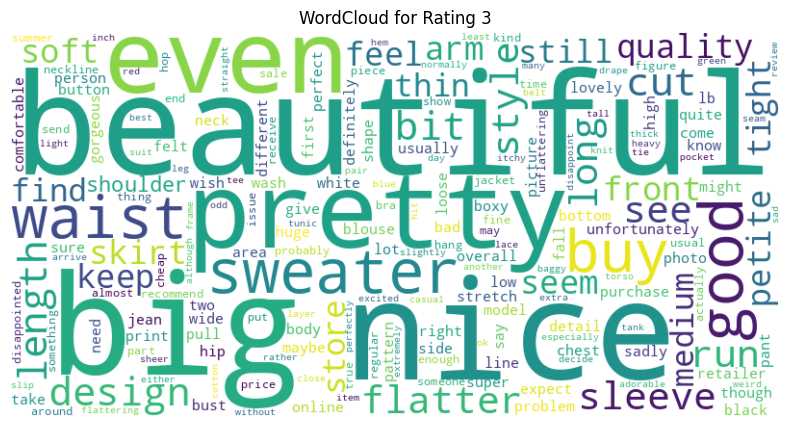

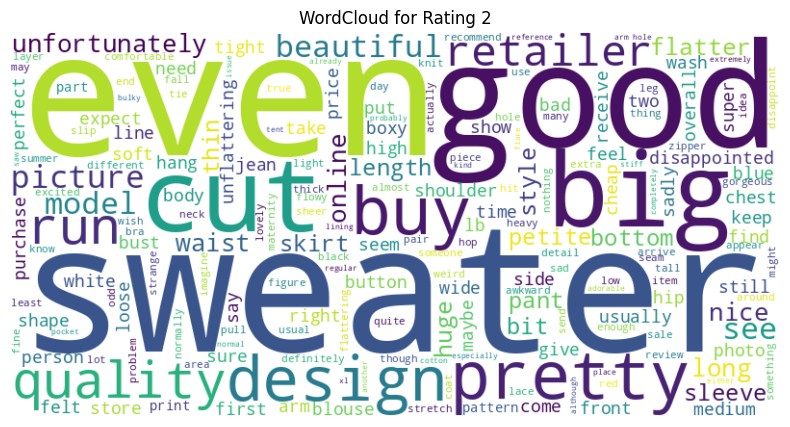

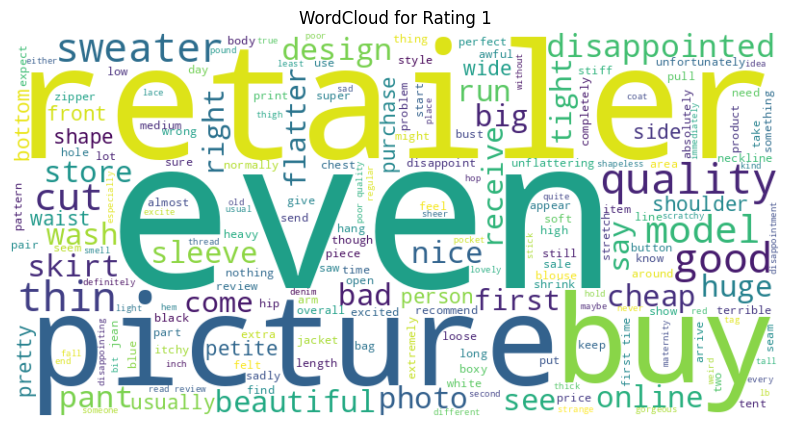

In [ ]:
for rating in df_multi['rating'].unique():
    reviews = df_multi[df_multi['rating'] == rating]['text']
    processed_text = ' '.join(reviews)
    create_wordcloud(processed_text, f'WordCloud for Rating {rating}')

Определим слова, которые часто пересекаются в различных классах

In [ ]:
# Создаем словарь для хранения частот слов по классам
class_word_freq = {1: Counter(), 2: Counter(), 3: Counter(), 4: Counter(), 5: Counter()}

# Заполняем словарь частот и считаем общее количество слов в каждом классе
class_total_words = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for rating, text in zip(df_multi['rating'], df_multi['text']):
    words = text.split()
    class_word_freq[rating].update(words)
    class_total_words[rating] += len(words)

# Функция для нахождения общих частых слов
def find_common_frequent_words(threshold_percent=1):
    common_words = {}
    all_words = set()
    for freq in class_word_freq.values():
        all_words.update(freq.keys())

    for word in all_words:
        classes = [rating for rating, freq in class_word_freq.items()
                   if (freq[word] / class_total_words[rating]) * 100 >= threshold_percent]
        if len(classes) > 1:
            common_words[word] = classes
    return common_words

# Находим общие частые слова
common_frequent_words = find_common_frequent_words(threshold_percent=1)  # Порог частоты в процентах

# Выводим результаты
for word, classes in common_frequent_words.items():
    print(f"Слово '{word}' часто встречается в классах: {classes}")
    for cls in classes:
        word_count = class_word_freq[cls][word]
        total_words = class_total_words[cls]
        percentage = (word_count / total_words) * 100
        print(f"  Класс {cls}: {percentage:.2f}% слов в классе {cls}")
    print()

In [ ]:
df_multi = df_multi.drop('labels', axis=1)
df_multi = df_multi.rename(columns={'rating': 'labels'})

In [ ]:
df_multi['labels'] = df_multi['labels'].apply(lambda x: x-1)

In [ ]:
# Сохранение предобработанного датасета
df_multi.to_csv('preprocessed_data_multiclassification.csv', index=False)

## Многоклассовая классификация (бонусное задание) - классификация

Среди множества предобученных моделей для данной задачи хорошо подошла `disilroberta-base`

In [ ]:
distilroberta_base = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(distilroberta_base)
model = AutoModelForSequenceClassification.from_pretrained(distilroberta_base, num_labels=5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
full_dataset = load_dataset('csv', data_files='preprocessed_data_multiclassification.csv')
full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)

full_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/22641 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 22631
    })
})

In [ ]:
tokenizer.tokenize(full_dataset['train'][1]['text'])

['so',
 'oo',
 'Ġpretty',
 'Ġhappen',
 'Ġfind',
 'Ġstore',
 'Ġglad',
 'Ġbc',
 'Ġnever',
 'Ġonline',
 'Ġbc',
 'Ġpet',
 'ite',
 'Ġbuy',
 'Ġpet',
 'ite',
 'Ġlength',
 'Ġhit',
 'Ġknee',
 'Ġdefinitely',
 'Ġtrue',
 'Ġmid',
 'i',
 'Ġsomeone',
 'Ġtruly',
 'Ġpet',
 'ite']

In [ ]:
dataset = full_dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 18104
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4527
    })
})

In [ ]:
pd.Series(dataset['test']['labels']).value_counts()

4    2444
3    1018
2     564
1     334
0     167
Name: count, dtype: int64

In [ ]:
# визуализируем один пример
dataset['train'][0]

{'text': 'feel soft good quality however run long loose tank almost tunic height even cardigan give shape also shrink dryer also wrinkle easily',
 'labels': 2}

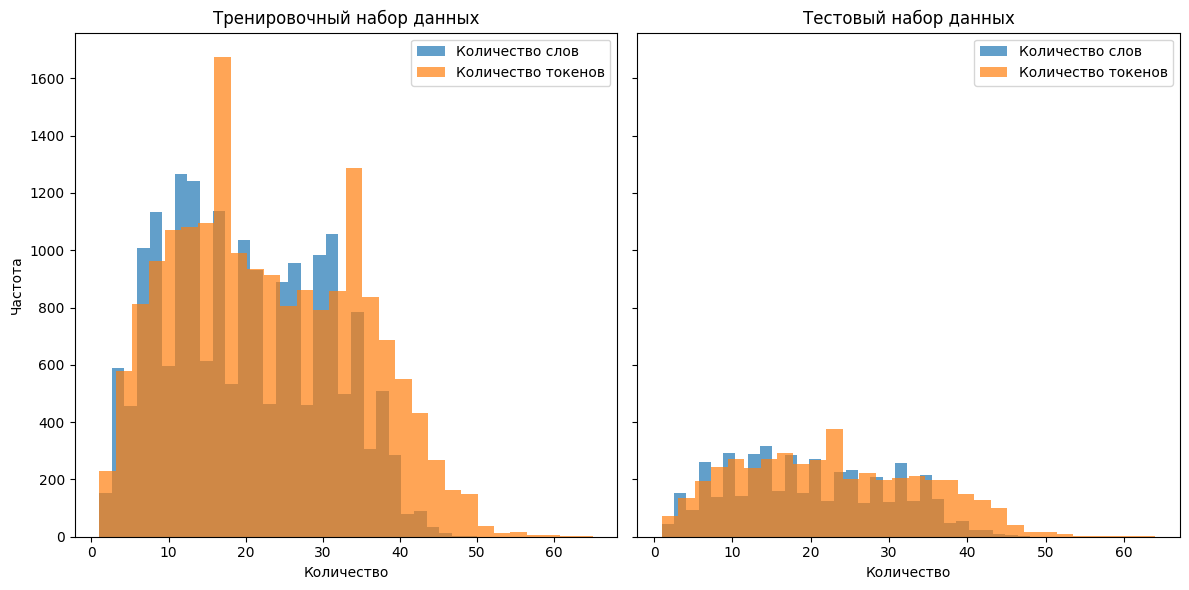

In [ ]:
# Подсчет количества слов и токенов с использованием токенизатора
train_word_counts = [len(example['text'].split()) for example in dataset['train']]

train_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['train']]

test_word_counts = [len(example['text'].split()) for example in dataset['test']]
test_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['test']]

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Гистограмма для тренировочного набора данных
axes[0].hist(train_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[0].set_title('Тренировочный набор данных')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Частота')
axes[0].legend()

# Гистограмма для тестового набора данных
axes[1].hist(test_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[1].hist(test_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[1].set_title('Тестовый набор данных')
axes[1].set_xlabel('Количество')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=80,
                                padding='max_length'), batched=True)

Map:   0%|          | 0/18104 [00:00<?, ? examples/s]

Map:   0%|          | 0/4527 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 18104
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4527
    })
})

In [ ]:
dataset = dataset.remove_columns(['text'])

In [ ]:
# переносим на гпу
dataset.set_format(type='torch', device='cuda')

In [ ]:
# создаем загрузчики данных
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=16)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=8)

In [ ]:
next(iter(train_dataloader))

{'labels': tensor([2, 4, 4, 2, 4, 4, 4, 1, 2, 4, 2, 4, 4, 2, 4, 4], device='cuda:0'),
 'input_ids': tensor([[    0, 29126, 19495,  ...,     1,     1,     1],
         [    0, 12005,  2985,  ...,     1,     1,     1],
         [    0, 13713,  1459,  ...,     1,     1,     1],
         ...,
         [    0, 28878, 16170,  ...,     1,     1,     1],
         [    0,  9902, 18028,  ...,     1,     1,     1],
         [    0, 35047,  5109,  ...,     1,     1,     1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-4)

num_epochs = 20

num_training_steps = num_epochs * len(train_dataloader)

# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps= int(0.1 * num_epochs * len(train_dataloader)), # ~10% от общего числа шагов оптимально
    num_training_steps=num_training_steps
)

In [ ]:
best_f1 = 0.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

running_loss = []
all_predictions = []
all_labels = []

for epoch in range(num_epochs):
    print(40*'-', f'\nEpoch {epoch+1}')

    # Переводим модель в режим обучения
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader), desc='Training')

    # Итерируемся по данным для обучения
    for i, batch in enumerate(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        # Получаем прогнозы и потери от модели
        outputs = model(**batch)
        loss = outputs.loss

        # Выполняем обратное распространение и шаг оптимизатора
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Обновляем планировщик скорости обучения
        optimizer.zero_grad()  # Очищаем градиенты

        running_loss.append(loss.item())
        pbar.set_postfix({'running_loss': np.mean(running_loss[-25:])})

    # Валидация модели
    print('\nValidating...')
    model.eval()  # Переводим модель в режим валидации

    # Инициализируем метрики
    f1 = load_metric('f1', trust_remote_code=True)
    acc = load_metric('accuracy', trust_remote_code=True)
    precision = load_metric('precision', trust_remote_code=True)
    recall = load_metric('recall', trust_remote_code=True)

    val_loss = []

    pbar = tqdm(test_dataloader, total=len(test_dataloader), desc='Validation')
    # Итерируемся по валидационным данным
    for batch in tqdm(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():  # Выполняем без расчета градиентов
            outputs = model(**batch)

        logits = outputs.logits.detach().cpu()
        predictions = torch.argmax(logits, dim=-1)

        # Сохраняем предсказания и метрики
        all_predictions.extend(predictions.tolist())
        all_labels.extend(batch["labels"].detach().cpu().tolist())

        # Обновляем метрики
        f1.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        acc.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        precision.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        recall.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())

        # Сохраняем потери
        val_loss.append(outputs.loss.item())
        pbar.set_postfix({'val_loss': np.mean(val_loss[-25:])})

    # Выводим итоги по метрикам
    print('Weighted Summary:')
    test_acc = acc.compute()['accuracy']
    test_precision = precision.compute(average='weighted')['precision']
    test_recall = recall.compute(average='weighted')['recall']
    f1_weighted = f1.compute(average='weighted')['f1']
    print(f'[{epoch+1}] Test Accuracy: {test_acc:.4f}')
    print(f'[{epoch+1}] Test Precision: {test_precision:.4f}')
    print(f'[{epoch+1}] Test Recall: {test_recall:.4f}')
    print(f'[{epoch+1}] Test F1: {f1_weighted:.4f}')

    # Сохраняем модель при улучшении F1
    if f1_weighted > best_f1:
        best_f1 = f1_weighted
        model.save_pretrained(f"multi_best_model_jul_2024_f1_max={best_f1}")
        print(f"New best F1: {best_f1}. Model saved.")

---------------------------------------- 
Epoch 1


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[1] Test Accuracy: 0.5847
[1] Test Precision: 0.5406
[1] Test Recall: 0.5847
[1] Test F1: 0.4749
New best F1: 0.4748797804854834. Model saved.
---------------------------------------- 
Epoch 2


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[2] Test Accuracy: 0.6269
[2] Test Precision: 0.5979
[2] Test Recall: 0.6269
[2] Test F1: 0.6034
New best F1: 0.6033866825602262. Model saved.
---------------------------------------- 
Epoch 3


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[3] Test Accuracy: 0.6218
[3] Test Precision: 0.5984
[3] Test Recall: 0.6218
[3] Test F1: 0.5965
---------------------------------------- 
Epoch 4


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[4] Test Accuracy: 0.5863
[4] Test Precision: 0.5861
[4] Test Recall: 0.5863
[4] Test F1: 0.5793
---------------------------------------- 
Epoch 5


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[5] Test Accuracy: 0.5951
[5] Test Precision: 0.5876
[5] Test Recall: 0.5951
[5] Test F1: 0.5892
---------------------------------------- 
Epoch 6


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[6] Test Accuracy: 0.5896
[6] Test Precision: 0.5908
[6] Test Recall: 0.5896
[6] Test F1: 0.5897
---------------------------------------- 
Epoch 7


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[7] Test Accuracy: 0.5750
[7] Test Precision: 0.5722
[7] Test Recall: 0.5750
[7] Test F1: 0.5717
---------------------------------------- 
Epoch 8


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[8] Test Accuracy: 0.5975
[8] Test Precision: 0.5933
[8] Test Recall: 0.5975
[8] Test F1: 0.5936
---------------------------------------- 
Epoch 9


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[9] Test Accuracy: 0.6035
[9] Test Precision: 0.5835
[9] Test Recall: 0.6035
[9] Test F1: 0.5885
---------------------------------------- 
Epoch 10


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[10] Test Accuracy: 0.5962
[10] Test Precision: 0.5813
[10] Test Recall: 0.5962
[10] Test F1: 0.5857
---------------------------------------- 
Epoch 11


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[11] Test Accuracy: 0.5951
[11] Test Precision: 0.5851
[11] Test Recall: 0.5951
[11] Test F1: 0.5890
---------------------------------------- 
Epoch 12


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[12] Test Accuracy: 0.5938
[12] Test Precision: 0.5794
[12] Test Recall: 0.5938
[12] Test F1: 0.5845
---------------------------------------- 
Epoch 13


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[13] Test Accuracy: 0.5849
[13] Test Precision: 0.5909
[13] Test Recall: 0.5849
[13] Test F1: 0.5863
---------------------------------------- 
Epoch 14


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[14] Test Accuracy: 0.5922
[14] Test Precision: 0.5958
[14] Test Recall: 0.5922
[14] Test F1: 0.5922
---------------------------------------- 
Epoch 15


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[15] Test Accuracy: 0.5944
[15] Test Precision: 0.5838
[15] Test Recall: 0.5944
[15] Test F1: 0.5867
---------------------------------------- 
Epoch 16


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[16] Test Accuracy: 0.5918
[16] Test Precision: 0.5901
[16] Test Recall: 0.5918
[16] Test F1: 0.5885
---------------------------------------- 
Epoch 17


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[17] Test Accuracy: 0.5933
[17] Test Precision: 0.5900
[17] Test Recall: 0.5933
[17] Test F1: 0.5894
---------------------------------------- 
Epoch 18


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[18] Test Accuracy: 0.5929
[18] Test Precision: 0.5883
[18] Test Recall: 0.5929
[18] Test F1: 0.5883
---------------------------------------- 
Epoch 19


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[19] Test Accuracy: 0.5900
[19] Test Precision: 0.5888
[19] Test Recall: 0.5900
[19] Test F1: 0.5872
---------------------------------------- 
Epoch 20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[20] Test Accuracy: 0.5953
[20] Test Precision: 0.5839
[20] Test Recall: 0.5953
[20] Test F1: 0.5863


Мы получили удовлетворительное качество - `0.6033866825602262`.

Посмотрим, где ошибается наш классификатор

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)

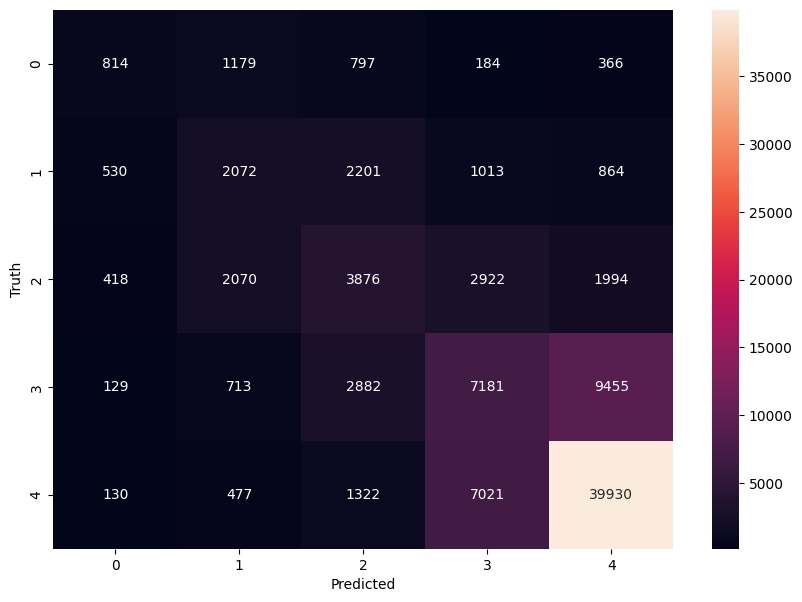

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

**Класс 0:**

Правильные классификации: 814 из 3340

Ошибок классификации: 2526

Путается с:

  - **классом 1: 1179 раз**
  - классом 2: 797 раз
  - классом 3: 184 раза
  - классом 4: 366 раз

---

**Класс 1:**

  Правильные классификации: 2072 из 6680

  Ошибки классификации: 4608

  Путается с:
  - классом 0: 530 раз
  - **классом 2: 2201 раз**
  - классом 3: 1013 раз
  - классом 4: 864 раза

---

**Класс 2:**

  Правильные классификации: 3876 из 11280

  Ошибки классификации: 7404

  Путается с:
  - классом 0: 418 раз
  - **классом 1: 2070 раз**
  - **классом 3: 2922 раза**
  - классом 4: 1994 раза

---

**Класс 3:**

  Правильные классификации: 7181 из 20360

  Ошибки классификации: 13179

  Путается с:
  - классом 0: 129 раз
  - классом 1: 713 раз
  - классом 2: 2882 раза
  - **классом 4: 9455 раз**

---

**Класс 4:**

  Правильные классификации: 39930 из 48880

  Ошибки классификации: 8950

  Путается с:
  - классом 0: 130 раз
  - классом 1: 477 раз
  - классом 2: 1322 раза
  - **классом 3: 7021 раз**

In [ ]:
num_classes = cm.shape[0]

print("Общая точность для каждого класса:")
for i in range(num_classes):
    correct_classifications = cm[i, i]
    total_class_samples = np.sum(cm[i])
    accuracy = correct_classifications / total_class_samples if total_class_samples > 0 else 0
    print(f"  Класс {i}: {accuracy:.2%}")

Общая точность для каждого класса:
  Класс 0: 24.37%
  Класс 1: 31.02%
  Класс 2: 34.36%
  Класс 3: 35.27%
  Класс 4: 81.69%


Вывод по бонусному заданию:

- классификатор имеет удовлетворительное значение f1
- классификатор достаточно хорошо способен различить лишь один класс (4)
- классификатор путает классы, которые находятся рядом по своему значению, например: 2 класс с 1 и 2.
- классификатор хорошо различает классы на расстоянии, например: класс 4 мало путается с классом 0.

Скорее всего, такой результат получился из-за несбалансированного датасета.